In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score

In [2]:
outliers = [
    [4000, 10, 50, 1000, -500, 9000, 300, 500, 300, 10000, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [1500, 300, 70, -300, 2000, 7000, 100, 50, 600, 12000, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
    [5000, 5, 1, 5000, 3000, 10000, 1000, 1500, 700, 15000, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
]
# Load the dataset
df = pd.read_csv(r'covtype.csv')

# Applying PCA for dimensionality reduction
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Prepare the data for ELM
global_out_liers_list = pd.DataFrame(principalDf)
print(global_out_liers_list)

        principal component 1  principal component 2
0                  674.821547            4634.599390
1                  543.787415            4651.724097
2                 2870.252673            3092.562608
3                 2839.580194            3216.681909
4                  516.489356            4606.119635
...                       ...                    ...
581007           -2538.746663             220.208733
581008           -2546.043906             234.007960
581009           -2545.907190             244.302746
581010           -2540.765125             252.666169
581011           -2554.559781             274.192752

[581012 rows x 2 columns]


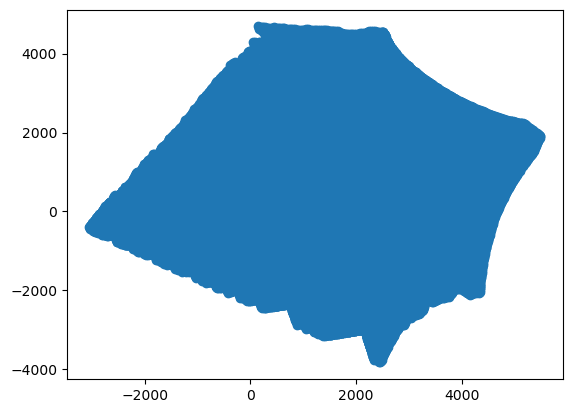

In [3]:

# Visualize the PCA result
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
plt.show()

In [4]:
principalDf.shape
print(principalDf)

        principal component 1  principal component 2
0                  674.821547            4634.599390
1                  543.787415            4651.724097
2                 2870.252673            3092.562608
3                 2839.580194            3216.681909
4                  516.489356            4606.119635
...                       ...                    ...
581007           -2538.746663             220.208733
581008           -2546.043906             234.007960
581009           -2545.907190             244.302746
581010           -2540.765125             252.666169
581011           -2554.559781             274.192752

[581012 rows x 2 columns]


In [5]:
# Define the ELMOutlierDetector class
class ELMOutlierDetector:
    def __init__(self, hidden_layer_size=100):
        self.hidden_layer_size = hidden_layer_size

    def fit(self, X):
        input_size = X.shape[1]
        self.hidden_weights = np.random.randn(input_size, self.hidden_layer_size)
        H = np.maximum(0, np.dot(X, self.hidden_weights))  # ReLU activation function
        self.output_weights = np.linalg.pinv(H)

    def predict(self, X):
        H = np.maximum(0, np.dot(X, self.hidden_weights))
        errors = np.linalg.norm(X - np.dot(H, self.hidden_weights), axis=1) #Euclidean distance
        return errors

In [6]:
# Injecting synthetic outliers into the dataset
num_synthetic_outliers = 10
synthetic_outliers = np.random.uniform(low=-1000, high=10000, size=(num_synthetic_outliers, global_out_liers_list.shape[1]))
df_with_synthetic_outliers = np.vstack([global_out_liers_list, synthetic_outliers])

# Add labels for synthetic outliers (1 for outlier, 0 for inliers)
true_labels = np.hstack([np.zeros(len(global_out_liers_list)), np.ones(num_synthetic_outliers)])

# Instantiate and use ELMOutlierDetector
elm_detector = ELMOutlierDetector(hidden_layer_size=df_with_synthetic_outliers.shape[1])
elm_detector.fit(df_with_synthetic_outliers)
outlier_scores = elm_detector.predict(df_with_synthetic_outliers)

# Identify outliers
threshold = np.percentile(outlier_scores, 99.999)
predicted_labels = (outlier_scores > threshold).astype(int)

In [7]:
# Calculate precision and recall
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Precision: 1.0000
Recall: 0.6000


In [8]:
original_data = df_with_synthetic_outliers[:-num_synthetic_outliers]
synthetic_outliers = df_with_synthetic_outliers[-num_synthetic_outliers:]

model_inliers = df_with_synthetic_outliers[predicted_labels == 0]
model_outliers = df_with_synthetic_outliers[predicted_labels == 1]

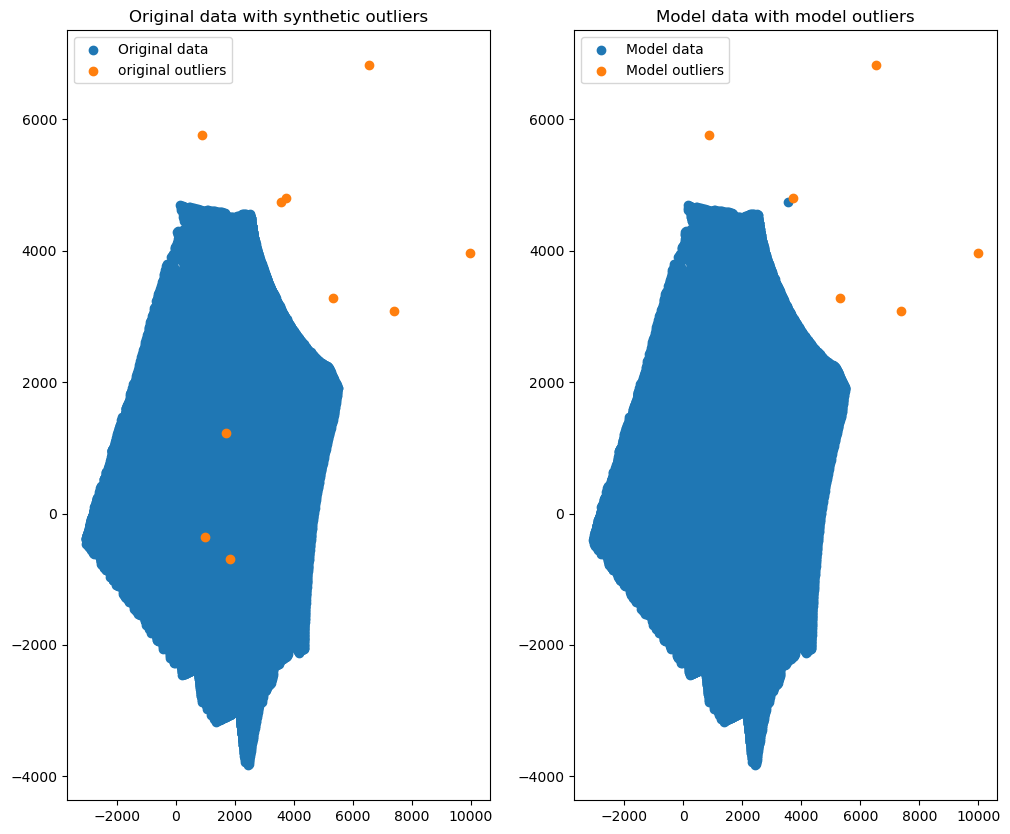

In [9]:
#plotting the original data and model data
plt.figure(figsize=(12, 10))

plt.subplot(1, 2, 1)
plt.scatter(original_data[:, 0], original_data[:, 1], label='Original data')
plt.scatter(synthetic_outliers[:, 0], synthetic_outliers[:, 1], label='original outliers')
plt.legend()
plt.title('Original data with synthetic outliers')

plt.subplot(1, 2, 2)
plt.scatter(model_inliers[:, 0], model_inliers[:, 1], label='Model data')
plt.scatter(model_outliers[:, 0], model_outliers[:, 1], label='Model outliers')
plt.legend()
plt.title('Model data with model outliers')

plt.show()
